# MPRA regression with K-fold cross validation

### Environment 
The next chunk contains the commands necessary to install the environment required to run this jupyter notebook
Skip this chunk if the installation was previously done

In [1]:
%%bash
conda create --name tf_MPRA python=3.9.7
conda activate tf_MPRA
pip install tensorflow[and-cuda]
conda install -c anaconda ipykernel 
conda install -c anaconda pandas
conda install -c anaconda numpy
conda install -c anaconda scikit-learn 
conda install -c conda-forge matplotlib

# After installation if you are using VSCODE to run the notebook you have to close it and re-open


Remove existing environment (y/[n])? Invalid choice: conda activate tf_mpra
Remove existing environment (y/[n])? Invalid choice: pip install tensorflow[and-cuda]
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda ipykernel
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda pandas
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda numpy
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda scikit-learn
Remove existing environment (y/[n])? Invalid choice: conda install -c conda-forge matplotlib
Remove existing environment (y/[n])? 



CondaSystemExit: Exiting.



### Library imports


In [2]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
from tensorflow.keras.layers import Normalization
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow import keras


2023-11-13 12:46:44.442286: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 12:46:44.577446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 12:46:44.577487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 12:46:44.578091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 12:46:44.626510: I tensorflow/core/platform/cpu_feature_g

### Input ingestion

Here we define the methods to read and ingest data and we initialize the random seed.

Since we are processing the entire sequence the vocabulary is comprised of upper case nucleotides


In [3]:
np.random.seed(1337) # for reproducibility

# Lower case vocabulary
vocab = ["A", "G", "C", "T"]

# These are the defaults of the data reader method 
# (each column in the ingested csv must be initialized with the right data type, otherwise the data ingestion fails )
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)
table = tf.lookup.StaticVocabularyTable(table_init, 1)
defs = [0.] * 1 + [tf.constant([], dtype = "string")]

# Nadav dataset

def data_reader(file, batch_size=100, n_parse_threads=4):
    """Method for reading the data in an optimized way, can be used inside model.fit()
    
    Args:
        file (_type_): path to csv file
        batch_size (int, optional): _description_. Defaults to 100.
        n_parse_threads (int, optional): _description_. Defaults to 4.

    Returns:
        dataset.batch: batch dataset object 
    """
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset=dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    """Preprocessing method of a dataset object, one-hot-encodes the data

    Args:
        record (_type_): _description_

    Returns:
        X (2D np.array): one-hot-encoded input sequence
        Y (1D np.array): MPRA measurements

    """
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])
    chars_indeces = table.lookup(chars)
    X = tf.one_hot(chars_indeces, depth = len(vocab))
    Y = fields[0]
    return X,Y

2023-11-13 12:46:46.876916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21669 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


### k-fold cross validation split
Here we take the initial csv file and we split it in 3 partitions k times

It is possible to randomize the sequences and augment, since the masking of the model motifs was a better choice
for understanding the background this strategy is here commented out and not used


In [4]:
# CROSS VALIDATION (10 fold)
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

# Split the data in three partitions
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2008)

o=1
# For each fold we split again to get the third partition
for i in kf.split(whole_data):
    # Get train/test split and upper case all nucleotides
    train = whole_data.iloc[i[0]]
    train["seq"] = train['seq'].str.upper() 
    
    test =  whole_data.iloc[i[1]]
    test["seq"] = test['seq'].str.upper() 

    train, validation = train_test_split(train, test_size=0.11, random_state=42)
    
    train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1

train

/tmp/ipykernel_667371/1817506747.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["seq"] = train['seq'].str.upper()
/tmp/ipykernel_667371/1817506747.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["seq"] = test['seq'].str.upper()


,State_3E,seq
5786,0.053119,AGGACCGGATCAACTGGTGCTGCCGTCACAACGCACTGTGCTTGTT...
5873,-0.077200,AGGACCGGATCAACTGTACAGTTATAAGGTAATCTTGTTCGATAAA...
3331,0.011841,AGGACCGGATCAACTCGACCGGGGTCACCAGGATATTATCAGATGG...
539,-0.103969,AGGACCGGATCAACTAATTGATATTGGCGCGTGTATCCCGAATTTC...
1122,0.036170,AGGACCGGATCAACTACTTGTGTTCAGGCACGATTTCTATCGTCGG...
...,...,...
5792,0.151705,AGGACCGGATCAACTGGTGGTAGCCACCTAGGGATAGCATAGGAGG...
5980,-0.000154,AGGACCGGATCAACTGTCAGAACTGCTTTGCCGACCGCGCTTTCTT...
955,0.039057,AGGACCGGATCAACTACGTAGTGCTTTATACCATCGAACCACTGCG...
8448,0.091301,AGGACCGGATCAACTTTTGTGTAACGCTGTACGGGGCTGGAGATTT...


### Deep Learning model

Here we run the model which is based on this paper : 

https://doi.org/10.1101/2023.03.05.531189

I have added a Normalization layer parametrized with two parameters. 

In [5]:

df_test_10folds  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
corr_list = []

# We define a custom normalization layer to then compile on the model
class CustomNormalization(Layer):
    """Custom normalization layer that normalizes the output of the neural network"""
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)

# We define the method to compute the pearson correlation between prediction and ground truth
def pearson_correlation(x, y):
    """Computes Pearson Correlation between x and y
    Args:
        x (np.array): vector of predictions values
        y (np.array): vector of ground truth values

    Returns:
        (float): pearson correlation
    """
    n = len(x)
    
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation

import matplotlib.pyplot as plt
%matplotlib inline
# Define plotting function of loss
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()


#### Model training
Here we iterate through the folds and train the model

In [6]:

for i in range(1,11):
    
    # Define inputs
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
    
    # Read test data to then predict
    df_test = pd.read_csv(input_path_test)

    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape
    
    # Define and compile model
    inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
    layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
    layer = BatchNormalization()(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(0.3)(layer)
    layer = Flatten()(layer)
    layer = Dense(300, activation='sigmoid')(layer)  # 300
    layer = Dropout(0.3)(layer)
    layer = Dense(200, activation='sigmoid')(layer)  # 300
    predictions = Dense(1, activation='linear')(layer)
    norm_predictions = CustomNormalization()(predictions)  # Assuming "predictions" is your existing output

    model = Model(inputs=inputs, outputs=norm_predictions)
    model.summary()

    # Compile model
    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse", "mae", "mape"],
                )
    # Run model
    history=model.fit(data_reader(input_path_train, batch_size=200),
                            epochs=20,
                            validation_data=data_reader(input_path_valid,batch_size=100),
                            callbacks=None,
                            verbose=1)
    
    #After training we save the model weights to then run the contribution scores
    model_path = '/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/Model_CV'+str(i)+"_LibA_wide_pivot_state3.h5"
    model.save_weights(model_path, save_format='h5')
    
    # We predict the test data
    predicted = model.predict(data_reader(input_path_test,
                                                batch_size=100))

    # We fill the dataframe with predictions and fold annotation
    test_data = data_reader(input_path_test,batch_size=100)
    test_tensor = X = np.empty(shape=[0,1])
    for batch in test_data:
        test_tensor = np.append(test_tensor, batch[1])

    # Append fold to previous folds
    df_test["prediction"] = predicted
    df_test["fold"] = str(i)
    df_test_10folds = pd.concat([df_test_10folds, df_test], ignore_index=True)    

    # Append correlation coefficient and append to previous        
    corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
    corr_list.append(corr_coefficient)

df_test_10folds.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold.csv", index=False)
print(corr_list)
df_test_10folds

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout (Dropout)           (None, 256, 250)          0         
                                                                 
 batch_normalization (Batch  (None, 256, 250)          1000      
 Normalization)                                                  
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_1 (Bat  (None, 249, 250)          1000      
 chNormalization)                                            

2023-11-13 12:46:54.582784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-13 12:46:54.679193: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 12:46:54.775094: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 12:46:56.392035: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f344400b820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 12:46:56.392063: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-13 12:46:56.397436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 12:46:56.484694: I ./tensorflow/compiler/jit/device_comp

     34/Unknown - 8s 51ms/step - loss: 0.1259 - mse: 0.1259 - mae: 0.2639 - mape: 28670.8438

2023-11-13 12:47:00.401560: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 8s 74ms/step - loss: 0.1259 - mse: 0.1259 - mae: 0.2639 - mape: 28670.8438 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1015 - val_mape: 106.5220
Epoch 2/20
 3/34 [=>............................] - ETA: 0s - loss: 0.0336 - mse: 0.0336 - mae: 0.1410 - mape: 1364.6373

2023-11-13 12:47:01.140893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298
2023-11-13 12:47:01.140962: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 1s 34ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1290 - mape: 3606.7090 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0982 - val_mape: 357.6240
Epoch 3/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.1123 - mape: 6495.1416 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0993 - val_mape: 456.4308
Epoch 4/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0985 - mape: 13524.7031 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1004 - val_mape: 519.6781
Epoch 5/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0914 - mape: 9065.1982 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1039 - val_mape: 648.3964
Epoch 6/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0841 - mape: 7098.6445 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1030 - val_mape: 618.3217


2023-11-13 12:47:25.552543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
/tmp/ipykernel_667371/2768337520.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_10folds = pd.concat([df_test_10folds, df_test], ignore_index=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_5 (Dropout)         (None, 256, 250)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 256, 250)          1000      
 chNormalization)                                                
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_5 (Bat  (None, 249, 250)          1000      
 chNormalization)                                          

2023-11-13 12:47:30.591844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298
2023-11-13 12:47:30.591928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 4s 43ms/step - loss: 0.0728 - mse: 0.0728 - mae: 0.2084 - mape: 34517.2305 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1391 - val_mape: 2629.6531
Epoch 2/20
 3/34 [=>............................] - ETA: 0s - loss: 0.0292 - mse: 0.0292 - mae: 0.1344 - mape: 10338.6709

2023-11-13 12:47:30.976466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298
2023-11-13 12:47:30.976547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 1s 35ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1210 - mape: 2826.1545 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1020 - val_mape: 921.3037
Epoch 3/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1030 - mape: 9011.9648 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1039 - val_mape: 1122.2283
Epoch 4/20
34/34 [==============================] - 1s 36ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0899 - mape: 10702.3340 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1009 - val_mape: 768.2529
Epoch 5/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0821 - mape: 8651.8389 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1057 - val_mape: 1260.1055
Epoch 6/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0761 - mape: 12764.5420 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1171 - val_mape: 1866.6

2023-11-13 12:48:25.204740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_15 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_12 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_13 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-11-13 12:48:30.017812: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298
2023-11-13 12:48:30.017885: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 4s 42ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2240 - mape: 11697.7783 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1134 - val_mape: 222.8773
Epoch 2/20


2023-11-13 12:48:30.387824: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298
2023-11-13 12:48:30.387896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 1s 34ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1298 - mape: 22009.4961 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1002 - val_mape: 110.3536
Epoch 3/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1097 - mape: 14177.2109 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1066 - val_mape: 170.7417
Epoch 4/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0968 - mape: 1152.6229 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1041 - val_mape: 148.2648
Epoch 5/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0877 - mape: 11523.9385 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1107 - val_mape: 203.4537
Epoch 6/20
34/34 [==============================] - 1s 33ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0783 - mape: 3031.8091 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1104 - val_mape: 200.535

2023-11-13 12:48:54.551789: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_20 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_16 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_17 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-11-13 12:49:28.836888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 4s 45ms/step - loss: 0.0791 - mse: 0.0791 - mae: 0.2140 - mape: 1843.7025 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1152 - val_mape: 827.4606
Epoch 2/20
 3/34 [=>............................] - ETA: 0s - loss: 0.0339 - mse: 0.0339 - mae: 0.1376 - mape: 402.6818

2023-11-13 12:49:29.336124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298


34/34 [==============================] - 1s 35ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1233 - mape: 1330.7831 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1027 - val_mape: 535.7078
Epoch 3/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1092 - mape: 1226.3835 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1022 - val_mape: 897.7667
Epoch 4/20
34/34 [==============================] - 1s 33ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0940 - mape: 1051.9601 - val_loss: 0.0256 - val_mse: 0.0256 - val_mae: 0.1056 - val_mape: 100.4826
Epoch 5/20
34/34 [==============================] - 1s 33ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0836 - mape: 724.2888 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.1069 - val_mape: 222.2729
Epoch 6/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0768 - mape: 911.4440 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1093 - val_mape: 428.2037
Epo

2023-11-13 12:49:59.423499: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 4s 44ms/step - loss: 0.0571 - mse: 0.0571 - mae: 0.1830 - mape: 1769.6396 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0949 - val_mape: 9919.5225
Epoch 2/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1136 - mape: 1120.3253 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0940 - val_mape: 28469.9355
Epoch 3/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0981 - mape: 1137.3082 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0957 - val_mape: 52580.9180
Epoch 4/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0848 - mape: 998.8790 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0963 - val_mape: 57772.6680
Epoch 5/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0754 - mape: 820.8917 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0997 - val_mape: 75529

2023-11-13 12:50:29.561095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298


34/34 [==============================] - 1s 37ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1205 - mape: 1096.3005 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0969 - val_mape: 53829.3711
Epoch 3/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1031 - mape: 706.3000 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.0971 - val_mape: 55716.0391
Epoch 4/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0896 - mape: 802.3046 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.0954 - val_mape: 35428.0703
Epoch 5/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0804 - mape: 858.6725 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0968 - val_mape: 8145.4746
Epoch 6/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0729 - mape: 734.4293 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.0978 - val_mape: 1409.85

2023-11-13 12:51:00.300140: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4710803253545640298
2023-11-13 12:51:00.300227: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


34/34 [==============================] - 1s 35ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1278 - mape: 4643.9663 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.0954 - val_mape: 326.0264
Epoch 3/20
34/34 [==============================] - 1s 38ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1135 - mape: 7075.7241 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1045 - val_mape: 541.0201
Epoch 4/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0984 - mape: 5495.9536 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.0991 - val_mape: 216.6274
Epoch 5/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0867 - mape: 6499.8540 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1006 - val_mape: 316.6741
Epoch 6/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0774 - mape: 9057.4014 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0999 - val_mape: 272.1606
E

2023-11-13 12:51:24.900054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_45 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_36 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_37 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

,State_3E,seq,prediction,fold
0,-0.007714,AGGACCGGATCAACTAAACAACTCAAACAAGGGCTAATATAACCCA...,0.065327,1
1,0.137953,AGGACCGGATCAACTAAACACTAGTCATACTTAAAAATTGCAAGGA...,0.073747,1
2,-0.048706,AGGACCGGATCAACTAAACAGGTTCTGACGTATGCTCCTCTATGGA...,0.030066,1
3,-0.052804,AGGACCGGATCAACTAAACCCGAGCCTGCCTAGCCCTAGCTTCTCT...,0.077990,1
4,0.213652,AGGACCGGATCAACTAAACGGAGCAGAGTTAGTGTCAGGTCAAAAA...,0.056666,1
...,...,...,...,...
8473,0.167100,AGGACCGGATCAACTTTTCCGCCTTTTATTATCAGGACTTCACGGG...,0.013850,10
8474,0.099489,AGGACCGGATCAACTTTTCGCTCATTAGTACAGGGTATAACGGAAG...,-0.097034,10
8475,-0.046939,AGGACCGGATCAACTTTTGGTCGGTTGACGGTCGCCTTGATTATTC...,-0.069841,10
8476,0.093662,AGGACCGGATCAACTTTTTTATCTGGTTATCATTCTAGTCTAGTGC...,-0.074672,10


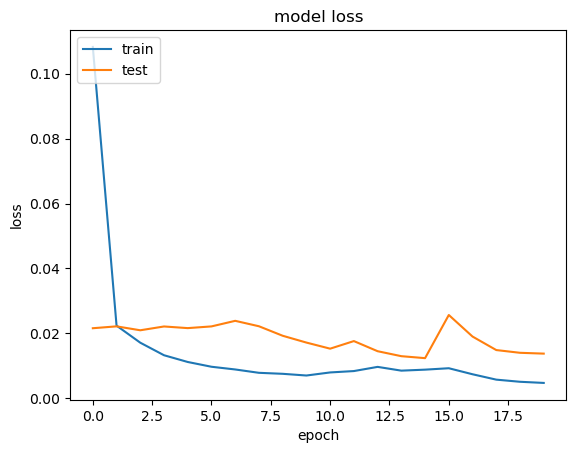

<Figure size 640x480 with 0 Axes>

In [9]:

create_plots(history)

# We now compute an ensemble approach we compute for each fold the model 10 times


In [8]:
df_test_10folds  = pd.DataFrame()
corr_list = []

for i in range(1,11):
    
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
   
    df_test = pd.read_csv(input_path_test)
    df_test["fold"] = str(i)
    corr_per_iteration = []
    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape
        
    for iteration in range(1,11):
        inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
        layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
        layer = Dropout(0.3)(layer)
        layer = BatchNormalization()(layer)
        layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
        layer = BatchNormalization()(layer)
        layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
        layer = Dropout(0.3)(layer)
        layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
        layer = BatchNormalization()(layer)
        layer = Dropout(0.3)(layer)
        layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
        layer = BatchNormalization()(layer)
        layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
        layer = Dropout(0.3)(layer)
        layer = Flatten()(layer)
        layer = Dense(300, activation='sigmoid')(layer)  # 300
        layer = Dropout(0.3)(layer)
        layer = Dense(200, activation='sigmoid')(layer)  # 300
        predictions = Dense(1, activation='linear')(layer)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer="adam",
                    loss="mean_squared_error",
                    metrics=["mse", "mae", "mape"],
                    )

        history=model.fit(data_reader(input_path_train, batch_size=100),
                                epochs=20,
                                validation_data=data_reader(input_path_valid,batch_size=100),
                                callbacks=None,
                                verbose=2)

        predicted = model.predict(data_reader(input_path_test,
                                                    batch_size=100))

        test_data = data_reader(input_path_test,batch_size=100)
        test_tensor = X = np.empty(shape=[0,1])
        for batch in test_data:
            test_tensor = np.append(test_tensor, batch[1])

        df_test["prediction_iteration_"+str(iteration)] = predicted
        
                
        corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
        corr_per_iteration.append(corr_coefficient)
    
    df_test_10folds = df_test_10folds.append(df_test, ignore_index=True)
    print(df_test_10folds)
        
    corr_ensemble = np.mean(corr_per_iteration)
    corr_list.append(corr_ensemble)

df_test_10folds.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold_ensemble.csv", index=False)

Epoch 1/20
68/68 - 5s - loss: 0.0442 - mse: 0.0442 - mae: 0.1573 - mape: 4651.8760 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.0984 - val_mape: 386.3610 - 5s/epoch - 73ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0182 - mse: 0.0182 - mae: 0.1043 - mape: 6573.6782 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0989 - val_mape: 431.1293 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0126 - mse: 0.0126 - mae: 0.0855 - mape: 8441.2119 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0989 - val_mape: 432.6306 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0802 - mape: 8915.3984 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.0981 - val_mape: 332.1422 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0106 - mse: 0.0106 - mae: 0.0794 - mape: 4484.3789 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.1293 - val_mape: 1167.5787 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0795 - mape: 1910.2388 - val_

2023-11-13 12:52:28.332734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


Epoch 1/20


2023-11-13 12:52:32.420228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
2023-11-13 12:52:32.420305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 4s - loss: 0.0647 - mse: 0.0647 - mae: 0.1857 - mape: 2723.6191 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1005 - val_mape: 523.0434 - 4s/epoch - 60ms/step
Epoch 2/20


2023-11-13 12:52:32.815826: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
2023-11-13 12:52:32.815898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 1s - loss: 0.0195 - mse: 0.0195 - mae: 0.1075 - mape: 24790.9082 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1034 - val_mape: 634.2174 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0142 - mse: 0.0142 - mae: 0.0914 - mape: 10731.8750 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1046 - val_mape: 673.6396 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0799 - mape: 9737.9609 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1128 - val_mape: 878.5895 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0762 - mape: 1142.1281 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1196 - val_mape: 1008.8282 - 1s/epoch - 19ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0092 - mse: 0.0092 - mae: 0.0739 - mape: 6754.9292 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1464 - val_mape: 1415.2301 - 1s/epoch - 19ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0736 - mape: 15028.8711 - val_loss: 0

2023-11-13 12:53:03.845832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


68/68 - 2s - loss: 0.0229 - mse: 0.0229 - mae: 0.1170 - mape: 18990.2812 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1131 - val_mape: 884.7284 - 2s/epoch - 23ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0167 - mse: 0.0167 - mae: 0.1001 - mape: 6870.8511 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1108 - val_mape: 835.1774 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0131 - mse: 0.0131 - mae: 0.0873 - mape: 13662.2129 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1090 - val_mape: 793.9219 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0797 - mape: 15264.2930 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1261 - val_mape: 1118.9170 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 2s - loss: 0.0098 - mse: 0.0098 - mae: 0.0754 - mape: 13782.8975 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1275 - val_mape: 1142.3826 - 2s/epoch - 22ms/step
Epoch 7/20
68/68 - 2s - loss: 0.0085 - mse: 0.0085 - mae: 0.0711 - mape: 5700.4556 - val_loss: 

2023-11-13 12:53:35.780937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
2023-11-13 12:53:35.781015: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 2s - loss: 0.0186 - mse: 0.0186 - mae: 0.1048 - mape: 4885.7173 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0990 - val_mape: 440.1450 - 2s/epoch - 26ms/step
Epoch 3/20
68/68 - 2s - loss: 0.0131 - mse: 0.0131 - mae: 0.0871 - mape: 1402.5748 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1009 - val_mape: 538.2029 - 2s/epoch - 25ms/step
Epoch 4/20
68/68 - 2s - loss: 0.0104 - mse: 0.0104 - mae: 0.0772 - mape: 22352.2090 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1099 - val_mape: 814.5352 - 2s/epoch - 27ms/step
Epoch 5/20
68/68 - 2s - loss: 0.0099 - mse: 0.0099 - mae: 0.0770 - mape: 9663.7822 - val_loss: 0.0326 - val_mse: 0.0326 - val_mae: 0.1526 - val_mape: 1497.4357 - 2s/epoch - 24ms/step
Epoch 6/20
68/68 - 2s - loss: 0.0093 - mse: 0.0093 - mae: 0.0747 - mape: 9136.3496 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0989 - val_mape: 439.1716 - 2s/epoch - 24ms/step
Epoch 7/20
68/68 - 2s - loss: 0.0078 - mse: 0.0078 - mae: 0.0679 - mape: 3781.4150 - val_loss: 0.02

2023-11-13 12:54:08.862554: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


Epoch 1/20
68/68 - 5s - loss: 0.0730 - mse: 0.0730 - mae: 0.1926 - mape: 34335.7109 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0982 - val_mape: 370.6967 - 5s/epoch - 67ms/step
Epoch 2/20


2023-11-13 12:54:13.892251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
2023-11-13 12:54:13.892334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 1s - loss: 0.0204 - mse: 0.0204 - mae: 0.1099 - mape: 8762.6914 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0996 - val_mape: 476.2711 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0150 - mse: 0.0150 - mae: 0.0938 - mape: 17263.4434 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1058 - val_mape: 707.3666 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0116 - mse: 0.0116 - mae: 0.0821 - mape: 3250.9780 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1127 - val_mape: 876.6499 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0767 - mape: 4383.1128 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1044 - val_mape: 667.6744 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0717 - mape: 1227.7538 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1192 - val_mape: 1003.4296 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0081 - mse: 0.0081 - mae: 0.0690 - mape: 2288.7139 - val_loss: 0.02

2023-11-13 12:54:44.591139: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
2023-11-13 12:54:44.591211: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 4s - loss: 0.0490 - mse: 0.0490 - mae: 0.1644 - mape: 26294.9043 - val_loss: 0.0222 - val_mse: 0.0222 - val_mae: 0.0988 - val_mape: 200.0979 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0186 - mse: 0.0186 - mae: 0.1050 - mape: 10036.1299 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.0983 - val_mape: 248.8860 - 1s/epoch - 22ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0139 - mse: 0.0139 - mae: 0.0900 - mape: 12848.6055 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1041 - val_mape: 175.6963 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0794 - mape: 3368.4150 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.0992 - val_mape: 168.8995 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0100 - mse: 0.0100 - mae: 0.0765 - mape: 2087.0620 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1000 - val_mape: 132.9371 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0734 - mape: 2046.3824 - val_loss: 0.0

2023-11-13 12:55:15.677663: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096


68/68 - 4s - loss: 0.0577 - mse: 0.0577 - mae: 0.1798 - mape: 7944.7671 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0997 - val_mape: 480.5628 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0193 - mse: 0.0193 - mae: 0.1065 - mape: 13892.4980 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1034 - val_mape: 632.5604 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0137 - mse: 0.0137 - mae: 0.0893 - mape: 17899.6191 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0989 - val_mape: 431.7386 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0788 - mape: 732.4716 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1026 - val_mape: 605.7069 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0752 - mape: 8175.0356 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.1055 - val_mape: 700.5739 - 1s/epoch - 19ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0723 - mape: 24314.8047 - val_loss: 0.02

2023-11-13 12:55:45.944992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4758399812689065096
2023-11-13 12:55:45.945071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 4s - loss: 0.0524 - mse: 0.0524 - mae: 0.1688 - mape: 48021.7969 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0989 - val_mape: 431.7624 - 4s/epoch - 58ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0196 - mse: 0.0196 - mae: 0.1079 - mape: 12646.4922 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0990 - val_mape: 437.5881 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0136 - mse: 0.0136 - mae: 0.0889 - mape: 3120.2908 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.0989 - val_mape: 189.6442 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0793 - mape: 8516.5244 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.0981 - val_mape: 291.4493 - 1s/epoch - 18ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0100 - mse: 0.0100 - mae: 0.0764 - mape: 9417.3145 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0996 - val_mape: 476.3716 - 1s/epoch - 18ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0092 - mse: 0.0092 - mae: 0.0737 - mape: 3028.6331 - val_loss: 0.02

2023-11-13 12:56:16.741406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 4s - loss: 0.1253 - mse: 0.1253 - mae: 0.2388 - mape: 10975.4932 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1014 - val_mape: 105.7062 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0227 - mse: 0.0227 - mae: 0.1167 - mape: 13979.4219 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1015 - val_mape: 107.8383 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0173 - mse: 0.0173 - mae: 0.1018 - mape: 2235.7063 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1007 - val_mape: 112.1908 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0133 - mse: 0.0133 - mae: 0.0894 - mape: 15986.1670 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1021 - val_mape: 125.1423 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0805 - mape: 3933.8306 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1017 - val_mape: 113.5774 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0093 - mse: 0.0093 - mae: 0.0742 - mape: 12114.0352 - val_loss: 0.

2023-11-13 12:56:48.423511: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


68/68 - 1s - loss: 0.0224 - mse: 0.0224 - mae: 0.1153 - mape: 7239.0337 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1109 - val_mape: 837.1691 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0171 - mse: 0.0171 - mae: 0.1010 - mape: 17583.5039 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1028 - val_mape: 613.9725 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0132 - mse: 0.0132 - mae: 0.0885 - mape: 8419.8047 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1107 - val_mape: 832.9368 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0809 - mape: 2609.2063 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1078 - val_mape: 763.2318 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0759 - mape: 5382.7769 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1110 - val_mape: 839.2021 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0723 - mape: 11757.5615 - val_loss: 0.02

2023-11-13 12:57:14.544901: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14849713808749010592


AttributeError: 'DataFrame' object has no attribute 'append'